In [1]:
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import os
import joblib
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score,accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, IsolationForest

from functools import reduce

from datetime import datetime
from datetime import datetime, timedelta
from time import time

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

from datetime import datetime
from datetime import datetime, timedelta
from time import time
from timeit import default_timer as timer
#start = timer()
#end = timer()
#print(end - start) 

import random

In [2]:
def under_sampling(original_features, original_labels):

    X = original_features
    y = original_labels
    undersample = RandomUnderSampler(sampling_strategy=0.8)
    X_under, y_under = undersample.fit_resample(X, y)
    malware_undersampled = X_under
    malware_undersampled['Label']=y_under
    print(f"Count after undersampling: \n{malware_undersampled['Label'].value_counts()}")
    print(f"Shape of dataset: \n{malware_undersampled.shape}")
    
    undersampled_features = malware_undersampled.drop(columns = ["Label"])
    undersampled_labels = malware_undersampled.Label

    return undersampled_features, undersampled_labels

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
  #  classes = unique_labels(y_true, y_pred)
    print('Confusion matrix')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# RAW DATASET (NOT NECESSARY)

malware = pd.read_csv('train_set.csv') # Read dataset
malware.head()

# malware.shape
print(f"Shape of original dataset: \n{malware.shape}")

# LABELSDsitributed data (0=benign and 1=malign)
print(f"Count original dataset: \n{malware['Label'].value_counts()}")

# Show all blank spaces in dataset (if any)
malware.isnull().sum() 

In [4]:
train_set = pd.read_csv('train_set.csv')
test_set = pd.read_csv('test_set.csv')

In [5]:
train_set.head()

,epoll_pwait epoll_pwait read,epoll_pwait read getuid,epoll_pwait read madvise,ioctl epoll_pwait read,madvise getuid epoll_pwait,read getuid epoll_pwait,read madvise getuid,epoll_pwait read futex,futex futex futex,futex futex getuid,...,fcntl64 pread64 mmap2,mmap2 gettimeofday getppid,close rt_sigprocmask gettimeofday,close gettimeofday pread64,getppid pread64 mmap2,pread64 mmap2 socket,fcntl close sendmsg,epoll_pwait ppoll recvmsg,ppoll recvmsg ioctl,Label
0,56,62,0,6,0,63,0.0,7,131,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5,3,0,1,0,4,0.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0.0,0,43,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
x_train = train_set.drop(columns = ['Label'])
y_train = train_set.Label
x_test = test_set.drop(columns = ['Label'])
y_test = test_set.Label

In [7]:
y_train

0        0.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
31406    0.0
31407    0.0
31408    1.0
31409    1.0
31410    0.0
Name: Label, Length: 31411, dtype: float64

In [8]:
print(f"Shape of LABEL VECTOR: \n{y_train.shape}")

Shape of LABEL VECTOR: 
(31411,)


In [9]:
y_train.shape[0]

31411

In [10]:
z_train=np.zeros(y_train.shape[0])
z_train

array([0., 0., 0., ..., 0., 0., 0.])

#z_train=np.zeros(y_train.shape[0])
z_train=train_set.Label
a=0;b=0;
for l in range(0,31410):
    c=y_train[l];
    if (c==0):
        z_train[l]=1
        a=a+1
    else:
        z_train[l]=0
        b=b+1
    
print(f"Original label vector: \n{y_train}")
print(f"Poisoned label vector: \n{z_train}")
    

#z_train=np.zeros(y_train.shape[0])
z_train=train_set.Label
a=0;b=0;
kpoison=0.2
rate_poison=kpoison*31410;
for l in range(0,31410):
    if((a+b)<rate_poison):
        c=y_train[l];
        if (c==0):
            z_train[l]=1
            a=a+1
        else:
            z_train[l]=0
            b=b+1
    
print(f"Original label vector: \n{y_train}")
print(f"Poisoned label vector: \n{z_train}")
    

In [11]:
#z_train=np.zeros(y_train.shape[0])
z_train=train_set.Label
a=0;b=0;
kpoison=1.0
rate_poison=round(kpoison*31410);

for l in range(0,rate_poison):
    location=random.randint(0,31410)
    #if((a+b)<rate_poison):
    c=y_train[location];
    if (c==0):
        z_train[location]=1
        a=a+1
    else:
        z_train[location]=0
        b=b+1
    
print(f"Original label vector: \n{y_train}")
print(f"Poisoned label vector: \n{z_train}")


Original label vector: 
0        1.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
31406    0.0
31407    0.0
31408    0.0
31409    1.0
31410    1.0
Name: Label, Length: 31411, dtype: float64
Poisoned label vector: 
0        1.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
31406    0.0
31407    0.0
31408    0.0
31409    1.0
31410    1.0
Name: Label, Length: 31411, dtype: float64


In [12]:
location=random.randint(0,31410)
location

21704

In [13]:
a+b

31410

In [14]:
dt=DecisionTreeClassifier(random_state=10)
dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=10)

Confusion matrix
[[2634 1993]
 [1415 1811]]


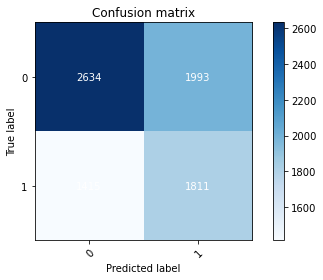

The accuracy is: 0.5660257226537629
The precision is: 0.47607781282860145
The recall is: 0.5613763174209547
The f1 score is: 0.5152204836415363
The auc score is: 0.5653218306361312


In [15]:
y_predicted = dt.predict(x_test).astype(int)
plot_confusion_matrix(y_test, y_predicted, classes=unique_labels(y_test.astype(int), y_predicted), title='Confusion matrix')
plt.show()
print(f"The accuracy is: {accuracy_score(y_test, y_predicted)}")
print(f"The precision is: {precision_score(y_test, y_predicted)}")
print(f"The recall is: {recall_score(y_test, y_predicted)}")
print(f"The f1 score is: {f1_score(y_test, y_predicted)}")
print(f"The auc score is: {roc_auc_score(y_test, y_predicted)}")
y_predicted = pd.DataFrame(y_predicted)
test_set_prediction = x_test
test_set_prediction['Predicted Label'] = y_predicted
test_set_prediction.to_csv('test_set_prediction.csv',index=False)